<a href="https://colab.research.google.com/github/LikaOkudzhava/BrainyScan/blob/InceptionV3/Alzheimer_model_inceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from imblearn.over_sampling import SMOTE

In [ ]:
import os

import zipfile

from google.colab import drive

gdrive = '/content/drive'

gdisk = os.path.join(gdrive, 'MyDrive')

filename = 'smallpreprocessed'

archive_path = os.path.join(gdisk, filename)

with zipfile.ZipFile('/content/drive/MyDrive/AI/smallpreprocessed.zip', 'r') as zip_ref:

 zip_ref.extractall(f'{filename}')

In [ ]:
dataset_dir = '/content/smallpreprocessed/data/SmallPreprocessed'
image_height = 224
image_width = 224
batch_size = 16


train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'train'),
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'test'),
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'val'),
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = True
)

for ds in [train_ds, test_ds, val_ds]:
    ds.cache()
    ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 12000 files belonging to 4 classes.
Found 2000 files belonging to 4 classes.
Found 2000 files belonging to 4 classes.


In [ ]:
from tensorflow import keras
import tensorflow as tf

# Set image dimensions for InceptionV3
image_height = 224
image_width = 224

# Define the model
model = keras.models.Sequential()

# Add InceptionV3 base model
model.add(
    tf.keras.applications.InceptionV3(
        input_shape=(image_height, image_width, 3),
        include_top=False,
        pooling='avg',
        weights='imagenet'
    )
)

# Add custom classifier layers
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(4, activation='softmax'))  # 4 classes

# Freeze base InceptionV3 layers
model.layers[0].trainable = False

# Build the model
model.build(input_shape=(None, image_height, image_width, 3))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,121,892 (107.28 MB)

 Trainable params: 6,308,868 (24.07 MB)

 Non-trainable params: 21,813,024 (83.21 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model Checkpoint - save only the best model
checkpoint_cb = ModelCheckpoint(
    "model_InceptionV3.keras",  # Updated filename
    save_best_only=True
)

# Early Stopping - stop if no improvement for 10 epochs
early_stopping_cb = EarlyStopping(
    patience=10,
    restore_best_weights=True
)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
EPOCHS = 25

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb]
)



Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 62s 59ms/step - accuracy: 0.4484 - loss: 1.6253 - val_accuracy: 0.5860 - val_loss: 0.9462
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 36s 48ms/step - accuracy: 0.5698 - loss: 1.0110 - val_accuracy: 0.6260 - val_loss: 0.8763
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.6190 - loss: 0.9152 - val_accuracy: 0.6425 - val_loss: 0.8074
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.6596 - loss: 0.8034 - val_accuracy: 0.7005 - val_loss: 0.7171
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.6831 - loss: 0.7705 - val_accuracy: 0.6940 - val_loss: 0.7951
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step - accuracy: 0.7192 - loss: 0.7073 - val_accuracy: 0.7160 - val_loss: 0.6925
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - accuracy: 0.7417 - loss: 0.6358 - val_accuracy: 0.7510 - val_loss: 0.5976
Epoch 8/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.7655 - loss: 0.5828 - 

In [3]:
model.save('/content/model_InceptionV3.keras')
model.export('/content/models/inceptionV3_model')

NameError: name 'model' is not defined

In [ ]:
score, acc= model.evaluate(test_ds)
print('Val Loss =', score)
print('Val Accuracy =', acc)

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8572 - loss: 0.4428
Val Loss = 0.5513023734092712
Val Accuracy = 0.8274999856948853


In [10]:
hist_=pd.DataFrame(history.history)

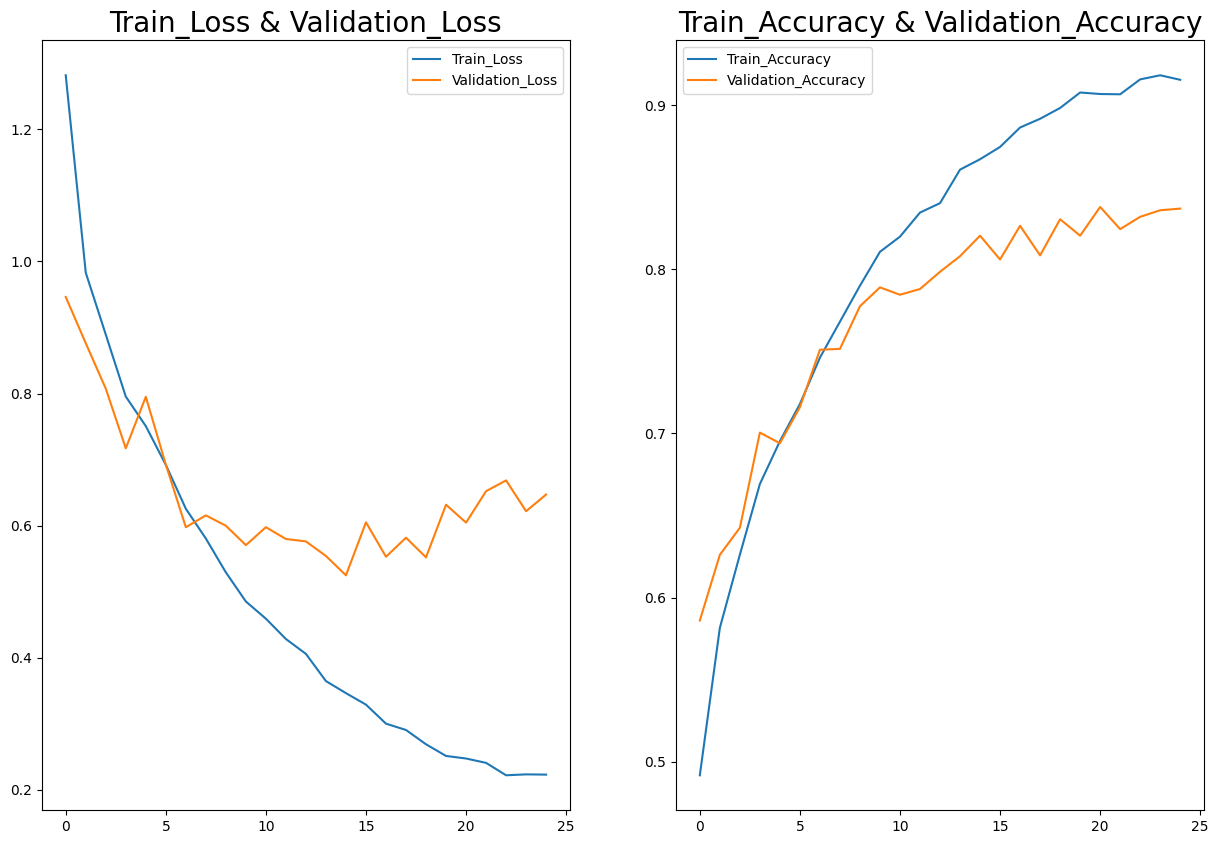

In [11]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [2]:
y_test_labels = []
for batch in test_ds:
    images, labels = batch
    y_test_labels.append(labels.numpy())

y_test = np.concatenate(y_test_labels, axis = 0)

predictions = model.predict(test_ds)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})

NameError: name 'test_ds' is not defined

In [14]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues',xticklabels=class_num, yticklabels=class_num)
CM

ValueError: Found input variables with inconsistent numbers of samples: [8000, 2000]

In [ ]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_num)
print('Classification Report is : ', ClassificationReport)

In [ ]:
!git push